In [1]:
import math
import numpy as np
import pandas as pd
import xarray as xr

import dask

import matplotlib.pyplot as plt

from SALib import ProblemSpec

In [2]:
# Kc timeseries
def construct_Kc(L_start, L_ini, L_dev, L_mid, L_late, Kc_ini, Kc_mid, Kc_end, K_min, K_max, lai):
    # Out
    Kc_out = np.empty(365)

    # Transition phases
    Kc_dev = np.linspace(Kc_ini, Kc_mid, L_dev)
    Kc_down = np.linspace(Kc_mid, Kc_end, L_late)
    
    # Loop through year
    for doy in range(365):
        if doy < L_start:
            Kc_out[doy] = K_min + (K_max - K_min) * (1 - np.exp(-0.7*lai[doy]))
        elif doy < (L_start + L_ini):
            Kc_out[doy] = Kc_ini
        elif doy < (L_start + L_ini + L_dev):
            Kc_out[doy] = Kc_dev[doy - (L_start + L_ini)]
        elif doy < (L_start + L_ini + L_dev + L_mid):
            Kc_out[doy] = Kc_mid
        elif doy < (L_start + L_ini + L_dev + L_mid + L_late):
            Kc_out[doy] = Kc_down[doy - (L_start + L_ini + L_dev + L_mid)]
        else:
            Kc_out[doy] = K_min + (K_max - K_min) * (1 - np.exp(-0.7*lai[doy]))

    return Kc_out

In [66]:
name = 'illinois'
lai = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_lai.txt")
Kc = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_kc.txt")

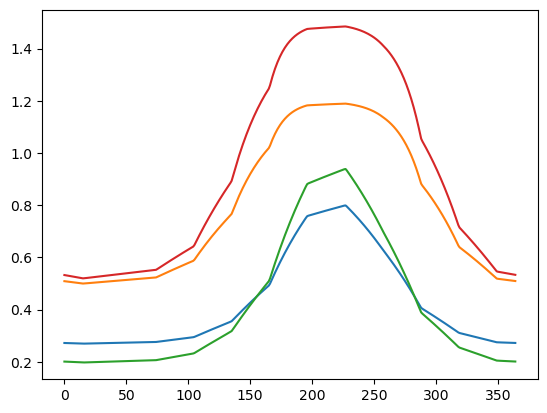

In [78]:
K_min = 0.2
K_max = 1.2
plt.plot([K_min + (K_max - K_min) * (1 - np.exp(-0.2*l)) for l in lai])
plt.plot([K_min + (K_max - K_min) * (1 - np.exp(-0.99*l)) for l in lai])

K_min = 0.1
K_max = 1.5
plt.plot([K_min + (K_max - K_min) * (1 - np.exp(-0.2*l)) for l in lai])
plt.plot([K_min + (K_max - K_min) * (1 - np.exp(-0.99*l)) for l in lai])

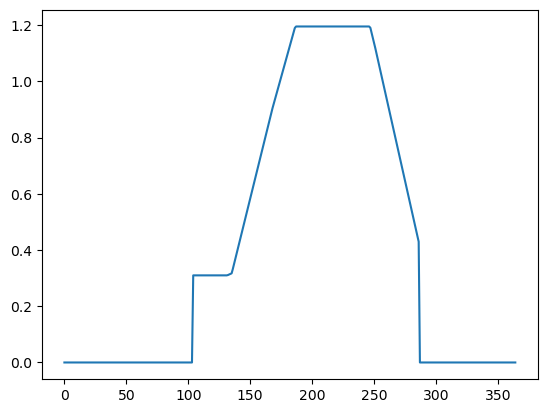

In [68]:
plt.plot(Kc)

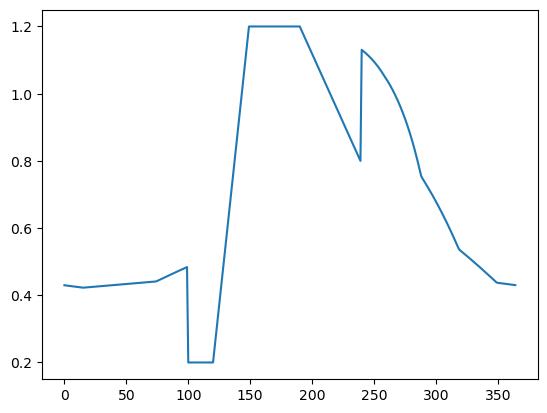

In [71]:
plt.plot(construct_Kc(100, 20, 30, 40, 50, 0.2, 1.2, 0.8, 0.2, 1.2, lai))

## Dask cluster

In [2]:
#### Distributed
# from dask_jobqueue import SLURMCluster

# cluster = SLURMCluster(
#     # account="pches",
#     account="open",
#     cores=1,
#     memory="5GB",
#     walltime="00:20:00",
# )

# cluster.scale(jobs=25)

In [3]:
# print(cluster.job_script())

In [3]:
#### Local
from dask.distributed import LocalCluster
cluster = LocalCluster()

In [4]:
from dask.distributed import Client

client = Client(cluster)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53265,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:53276,Total threads: 2
Dashboard: http://127.0.0.1:53278/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:53268,


## Model code

In [5]:
from water_balance import wbm

In [6]:
sp = ProblemSpec({
    'num_vars': 10,
    'names': ['Ts', 'Tm', 'Clai', 'awCap', 'wiltingp', 'alpha', 'betaHBV', 'Kmin', 'Kmax', 'Klai'],
    'bounds': [[-3, -1],
               [1, 3],
               [0.1, 0.5],
               [100, 1000],
               [100, 500], 
               [0.1, 10],
               [0.1, 10],
               [0.05, 0.25],
               [0.75, 1.5],
               [0.1, 0.99]]
}).sample_sobol(2**8)

np.savetxt('./param_values.txt', sp.samples)

In [13]:
def wbm_sa(location, iparam):
    ######################
    # Select state
    name = location
    ######################

    T = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_temperature.txt")
    P = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_precip.txt")
    lai = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_lai.txt")
    soilMoist = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_soilMoist.txt")[0]
    soilMoistFrac = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_soilMoistFrac.txt")
    Kc = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_kc.txt")

    # Select correct latitiude
    # SD: [44,-98]
    # IA: [42,-93]
    # IL: [40,-89]
    lat_dict = {"southdakota":44., "iowa":42., "illinois":40.}
    lat = lat_dict[name]
    
    ################
    # Inputs
    ################
    phi = lat          # Latitude

    Ws_init = soilMoist  # Initial soil moisture: take from WBM
    Wi_init = 0.5           # Canopy water storage
    Sp_init = 0.             # Snowpack

    # Make dicts
    initial_conditions = {}
    initial_conditions["Ws_init"] = Ws_init
    initial_conditions["Wi_init"] = Wi_init
    initial_conditions["Sp_init"] = Sp_init

    forcing_data = {}
    forcing_data["prcp"] = P
    forcing_data["tas"] = T
    
    parameters = {}
    X = np.loadtxt('/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_soilM_crop_uc_lafferty-etal-2024-tbd/code/param_values.txt', float)
    parameters["Ts"] = X[iparam][0]
    parameters["Tm"] = X[iparam][1]
    parameters['Clai'] = X[iparam][2]
    parameters["awCap"] = X[iparam][3]
    parameters["wiltingp"] = X[iparam][4]
    parameters["alpha"] = X[iparam][5]
    parameters["betaHBV"] = X[iparam][6]
    parameters["Kmin"] = X[iparam][7]
    parameters["Kmax"] = X[iparam][8]
    parameters["Klai"] = X[iparam][9]
    
    constants = {}
    constants["lai"] = lai
    constants["phi"] = phi
    constants["nt"] = len(T)-1
    constants["doy"] = np.arange(1,len(T)+1)
    constants["rootDepth"] = 1000.

    # run
    out = wbm(
        initial_conditions=initial_conditions,
        forcing_data=forcing_data,
        parameters=parameters,
        constants=constants,
    )
    # metric 
    return np.mean(out)

In [14]:
%%time
delayed = []

for i in range(len(sp.samples)):
    delayed.append(dask.delayed(wbm_sa('illinois', i)))

CPU times: user 1min 47s, sys: 10.3 s, total: 1min 57s
Wall time: 1min 53s


In [15]:
%%time
out = dask.compute(*delayed)

CPU times: user 4.87 s, sys: 462 ms, total: 5.33 s
Wall time: 5.54 s


In [16]:
sp.set_results(np.array(out));
sp.analyze_sobol();

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

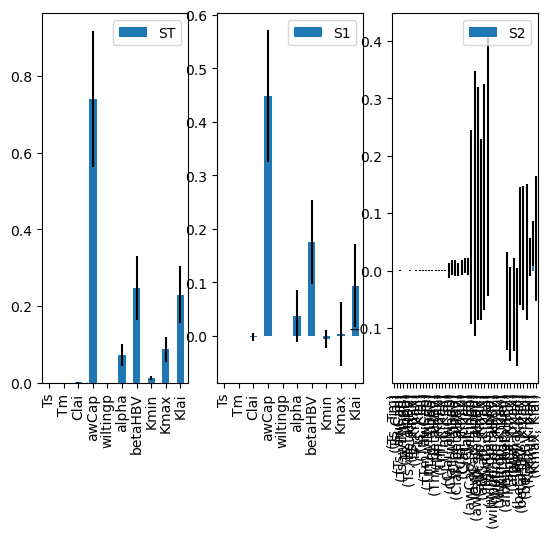

In [11]:
# var
sp.plot()

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

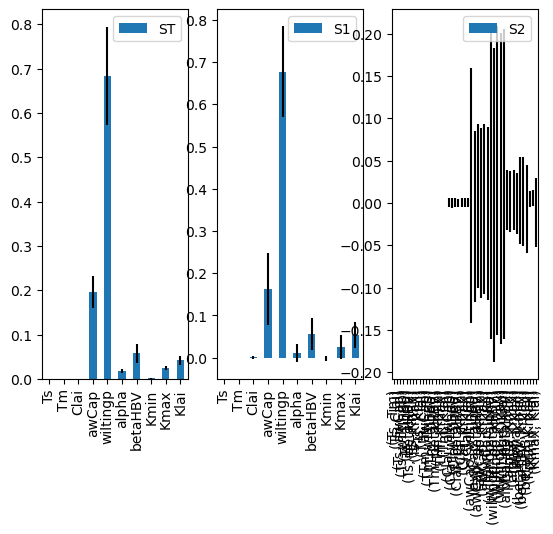

In [17]:
# mean
sp.plot()